# Pendulum on chart

## Includes

In [1]:
%matplotlib inline
import numpy as np
import sympy as sp
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from matplotlib import animation as ani

from IPython.display import HTML

## Init symbols and funtions

In [2]:
t, m, M, l, g, Fb = sp.symbols('t m M l g Fb' )
x = sp.Function('x')(t)
theta = sp.Function('theta')(t)
z1 = sp.Function('z1')(t)
z2 = sp.Function('z2')(t)
z3 = sp.Function('z3')(t)
z4 = sp.Function('z4')(t)
u  = sp.Function('u')(t)
F = sp.Function('F')(t)
genCoordinates = [z1,z2,z3,z4]

## Penulum on chart equations

In [3]:
xc = x
yc = 0
xm = x+l*sp.sin(theta)
ym = -l*sp.cos(theta)

In [4]:
eqCx = -m*xc.diff(t).diff(t) + F + Fb*sp.sin(theta)
eqMx = -M*xm.diff(t).diff(t) - Fb*sp.sin(theta)
eqMy = -M*ym.diff(t).diff(t) + Fb*sp.cos(theta) - M*g
EQ2 = (eqMx*sp.cos(theta)+eqMy*sp.sin(theta)).simplify()

In [5]:
Fb_eqn = (eqMx/sp.sin(theta)+Fb).simplify()
EQ1 = eqCx.subs({Fb: Fb_eqn}).simplify()

In [6]:
#EQ1=(M+m)*x.diff(t).diff(t)-m*l*theta.diff(t).diff(t)*sp.cos(theta)+m*l*(theta.diff(t))**2*sp.sin(theta)-F
#EQ1

In [7]:
#EQ2 = l*theta.diff(t).diff(t) - g*sp.sin(theta) - x.diff(t).diff(t)*sp.cos(theta)
#EQ2

## Generalized coordinates

In [8]:
genCoords = {x: z1, 
             x.diff(t): z2, 
             theta: z3, 
             theta.diff(t): 
             z4, F: u}
genCoords

{Derivative(theta(t), t): z4(t),
 Derivative(x(t), t): z2(t),
 F(t): u(t),
 theta(t): z3(t),
 x(t): z1(t)}

### Substitute into equations

In [9]:
gEQ1 = EQ1.subs(genCoords)
gEQ1

M*l*z4(t)**2*sin(z3(t)) - M*l*cos(z3(t))*Derivative(z4(t), t) - M*Derivative(z2(t), t) - m*Derivative(z2(t), t) + u(t)

In [10]:
gEQ2 = EQ2.subs(genCoords)
gEQ2

-M*(g*sin(z3(t)) + l*Derivative(z4(t), t) + cos(z3(t))*Derivative(z2(t), t))

### Obtain the form $\dot{z}(t) = f(z)$

#### Solve equation 2 for $\dot{z}_2$ and $\dot{z}_4$, 

In [11]:
sol_dz4 = sp.solve(gEQ2,z4.diff(t))[0]
sol_dz4

-(g*sin(z3(t)) + cos(z3(t))*Derivative(z2(t), t))/l

In [12]:
sol_dz2 = sp.solve(gEQ2,z2.diff(t))[0]
sol_dz2

-g*tan(z3(t)) - l*Derivative(z4(t), t)/cos(z3(t))

#### Substitute into equation 1

In [13]:
EQ_dz2 = gEQ1.subs({z4.diff(t):sol_dz4}).simplify()
EQ_dz2 = sp.solve(EQ_dz2,z2.diff(t))[0]
EQ_dz2

(M*g*sin(2*z3(t))/2 + M*l*z4(t)**2*sin(z3(t)) + u(t))/(M*sin(z3(t))**2 + m)

In [14]:
EQ_dz4 = gEQ1.subs({z2.diff(t):sol_dz2}).simplify()
EQ_dz4 = sp.solve(EQ_dz4,z4.diff(t))[0]
EQ_dz4

-(M*g*sin(z3(t)) + M*l*z4(t)**2*sin(2*z3(t))/2 + g*m*sin(z3(t)) + u(t)*cos(z3(t)))/(l*(M*sin(z3(t))**2 + m))

#### Get desired nonlinear function

In [15]:
gFun = []
gFun.append(z2)
gFun.append(EQ_dz2)
gFun.append(z4)
gFun.append(EQ_dz4)
gFun

[z2(t),
 (M*g*sin(2*z3(t))/2 + M*l*z4(t)**2*sin(z3(t)) + u(t))/(M*sin(z3(t))**2 + m),
 z4(t),
 -(M*g*sin(z3(t)) + M*l*z4(t)**2*sin(2*z3(t))/2 + g*m*sin(z3(t)) + u(t)*cos(z3(t)))/(l*(M*sin(z3(t))**2 + m))]

In [17]:
class NLDiffEQN:
    # List of state variables
    states = None
    nStates = 0
    # List of input variables
    inputs = None
    nInputs = 0
    # Dict of constants in equations
    constants = None
    
    # List of symbolic nonlinear equations
    equationsNL = None
    nEquations = 0
    # List of symbolic nonlinear equations (constants substituted)
    equationsNLc = None
    
    # A and B matrix of linear, time-varying, continuous system
    Acltv = None
    Bcltv = None
    
    # Constructor
    def __init__(self,equations,states,inputs,constants = dict({})):
        self.equationsNL = equations
        self.equationsNLc = [0]*len(equations)
        self.nEquations = len(equations)
        if len(constants) != 0:
            for i, e in enumerate(equations):
                self.equationsNLc[i] = e.subs(constants)
        self.states = states
        self.nStates = len(states)
        self.inputs = inputs
        self.nInputs = len(inputs)
        self.constants = constants
        
        self.setCLS()
    
        
    def dfdtNL(self,zv,t,uv):
        res = [0]*len(zv)
        z  = dict({z1: zv[0],
                   z2: zv[1],
                   z3: zv[2],
                   z4: zv[3],
                   u: uv[0]})
        for i, e in enumerate(self.equationsNLc):
            res[i] = e.subs(z).evalf()
        return res
    
    def setCLS(self):
        nz = self.nStates
        nu = self.nInputs
        # Init A and B matrix
        A = [[0 for x in range(nz)] for y in range(nz)]
        B = [[0 for x in range(nu)] for y in range(nz)]
    
        # Linearize system
        for i, eq in enumerate(self.equationsNL):
            # Populate A matrix
            for j, z in enumerate(self.states):
                A[i][j] = eq.diff(z)
            # Populate B matrix
            for j, u in enumerate(self.inputs):
                B[i][j] = eq.diff(u)
        self.Acltv = A
        self.Bcltv = B
    def getCLS(self, zv):
        # here return A, B time varying
        pass
    def dfdtL(self,zv,t,uv):
        z = np.array(zv);
        u = np.array(uv);
        self.A
    

In [18]:
const = dict({M: 1,
              m: 100,
              g: 9.81,
              l: 1})
Nt = 201
tmax = 20
t = np.linspace(0, tmax, Nt)
nldiff = NLDiffEQN(gFun,[z1, z2, z3, z4],[u],const)

In [19]:
resNL = odeint(nldiff.dfdtNL,[0,0,0.2,0],t,args=([0],))
res = [resNL]

In [20]:
def drawCartPendulum(i, data, col):
    # Chart position
    xc = data[i,0]
    yc = 0
    ax1.scatter(xc,yc,s=40,c=col)
    
    # Position of mass
    theta = data[i,2]
    xm = xc+np.sin(theta)
    ym = -np.cos(theta)
    ax1.scatter(xm,ym,s=150,c=col)
    
    # Draw line
    ax1.plot([xc,xm],[yc,ym],c=col)

def animate2(i,data):
    ax1.clear()
    for d in data:
        drawCartPendulum(i, d, 'b')
        
    plt.xlim(-1, 1)

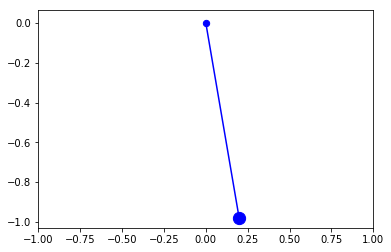

In [21]:
#plt.plot(t, deqn[:,1])
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
an = ani.FuncAnimation(fig, animate2, frames=len(res[0]),fargs=(res, ), interval=tmax/Nt*1000, repeat=False)
HTML(an.to_html5_video())

In [24]:
EQ_point = {z1: 0, z2: 0, z3: 0, z4: 0}

In [25]:
EQ_x.subs(EQ_point)

NameError: name 'EQ_x' is not defined

In [ ]:
EQ_theta.subs(EQ_point)

In [ ]:
f2.diff(z3).subs(EQ_point)

In [ ]:
f2.diff(z4).subs(EQ_point)

In [ ]:
f4.diff(z3).simplify().subs(EQ_point)

In [ ]:
f4.diff(z4).simplify().subs(EQ_point)

In [ ]:
len(gfun)
len(genCoordinates)
A = sp.zeros(len(gfun),len(genCoordinates))

In [ ]:
for i, g in enumerate(gfun):
    for j, c in enumerate(genCoordinates):
        A[i,j] = g.diff(c)
A
    